In [1]:
# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time
from datetime import datetime
from datetime import timedelta
import scipy as sp

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath = 'figures' # put in the same folder, but add to .gitignore for now

Connecting anneurai@datajoint.internationalbrainlab.org:3306


In [2]:
########### SUBJECTS ########### 

subj = subject.Subject * subject.SubjectLab * subject.SubjectProject & \
      'subject_project = "collab_citricacid"' & 'lab_name="mainenlab"'

########### WEIGHINGS ########### 

weight_with_date = subj * (action.WaterAdministration * action.Weighing).proj('weight', 
                                                                       'water_administered', 
                                                                       session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date < "2018-10-24"'
baseline_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date < "2018-09-24"'

avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)', total_water='AVG(water_administered)') 
avg_baseline_weight_date = baseline_date.aggr(weight_with_date, avg_weight = 'AVG(weight)')

b = subj * avg_weight_date 
bb = subj * avg_baseline_weight_date
weight_df = pd.DataFrame(b.fetch(as_dict=True))
baseline_df = pd.DataFrame(bb.fetch(as_dict=True))
weight_df.tail(n=5)

,subject_uuid,subject_project,session_date,subject_nickname,sex,subject_birth_date,ear_mark,subject_line,subject_source,protocol_number,subject_description,subject_ts,subject_strain,lab_name,subjectlab_ts,subjectproject_ts,avg_weight,total_water
437,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-10-10,ZM_338,M,2018-08-08,None,Thy1-GCaMP6s,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,C57BL/6J,mainenlab,2020-05-06 13:43:06,2020-05-06 13:42:50,19.469999,0.888
438,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-10-02,ZM_338,M,2018-08-08,None,Thy1-GCaMP6s,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,C57BL/6J,mainenlab,2020-05-06 13:43:06,2020-05-06 13:42:50,19.049999,0.888
439,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-10-22,ZM_338,M,2018-08-08,None,Thy1-GCaMP6s,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,C57BL/6J,mainenlab,2020-05-06 13:43:06,2020-05-06 13:42:50,20.719999,0.888
440,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-09-24,ZM_338,M,2018-08-08,None,Thy1-GCaMP6s,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,C57BL/6J,mainenlab,2020-05-06 13:43:06,2020-05-06 13:42:50,20.320000,0.888
441,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-10-11,ZM_338,M,2018-08-08,None,Thy1-GCaMP6s,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,C57BL/6J,mainenlab,2020-05-06 13:43:06,2020-05-06 13:42:50,19.719999,0.888


In [29]:
normalized_df = weight_df.copy()

# what are the ages in this cohort?
normalized_df['session_age'] = (datetime(2018, 9, 24).date() - normalized_df.subject_birth_date)
normalized_df['session_age'].describe()
# mean is 67 days = 9.5 weeks; so add the Jax weights at 9 weeks as day 0 

########### ADD JAX DATA ########### 
jax_weights = pd.read_csv('data/jax_mouse_weights.csv')
jax_weights.head(n=3)

for weeknr, group in jax_weights.groupby(['Weeks']):
    
    if 8 <= group.Weeks.mean().item() <= 16:
        normalized_df = normalized_df.append({'subject_nickname':'Jax_male',
                              'sex':'M',
                              'session_date':datetime(2018, 9, 24).date() + 
                                              timedelta(days=(group.Weeks.mean().item() - 9) * 7),
                              'avg_weight':group.Males.mean().item()}, ignore_index=True)
        
        normalized_df = normalized_df.append({'subject_nickname':'Jax_female',
                              'sex':'F',
                              'session_date':datetime(2018, 9, 24).date() + 
                                              timedelta(days=(group.Weeks.mean().item() - 9) * 7),
                              'avg_weight':group.Females.mean().item()}, ignore_index=True)
normalized_df

,subject_uuid,subject_project,session_date,subject_nickname,sex,subject_birth_date,ear_mark,subject_line,subject_source,protocol_number,subject_description,subject_ts,subject_strain,lab_name,subjectlab_ts,subjectproject_ts,avg_weight,total_water,session_age
0,0124f697-16ce-4f59-b87c-e53fcb3a27ac,collab_citricacid,2018-10-03,6867,M,2018-06-25,None,Thy1-GCaMP6s,CCU - Margarida colonies,1.0,None,2019-09-25 01:33:25,C57BL/6J,mainenlab,2020-05-06 13:42:52,2020-05-06 13:42:35,26.309999,1.241667,91 days 00:00:00
1,0124f697-16ce-4f59-b87c-e53fcb3a27ac,collab_citricacid,2018-10-23,6867,M,2018-06-25,None,Thy1-GCaMP6s,CCU - Margarida colonies,1.0,None,2019-09-25 01:33:25,C57BL/6J,mainenlab,2020-05-06 13:42:52,2020-05-06 13:42:35,25.590000,1.241667,91 days 00:00:00
2,0124f697-16ce-4f59-b87c-e53fcb3a27ac,collab_citricacid,2018-09-25,6867,M,2018-06-25,None,Thy1-GCaMP6s,CCU - Margarida colonies,1.0,None,2019-09-25 01:33:25,C57BL/6J,mainenlab,2020-05-06 13:42:52,2020-05-06 13:42:35,28.049999,1.241667,91 days 00:00:00
3,0124f697-16ce-4f59-b87c-e53fcb3a27ac,collab_citricacid,2018-10-12,6867,M,2018-06-25,None,Thy1-GCaMP6s,CCU - Margarida colonies,1.0,None,2019-09-25 01:33:25,C57BL/6J,mainenlab,2020-05-06 13:42:52,2020-05-06 13:42:35,26.059999,1.241667,91 days 00:00:00
4,0124f697-16ce-4f59-b87c-e53fcb3a27ac,collab_citricacid,2018-09-17,6867,M,2018-06-25,None,Thy1-GCaMP6s,CCU - Margarida colonies,1.0,None,2019-09-25 01:33:25,C57BL/6J,mainenlab,2020-05-06 13:42:52,2020-05-06 13:42:35,28.950001,1.241667,91 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,NaN,NaN,2018-10-29,Jax_female,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,NaN,NaN
456,NaN,NaN,2018-11-05,Jax_male,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.600000,NaN,NaN
457,NaN,NaN,2018-11-05,Jax_female,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.500000,NaN,NaN
458,NaN,NaN,2018-11-12,Jax_male,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.100000,NaN,NaN


In [30]:
########### WEIGHINGS NORMALIZATION  ########### 

# day 0 is the start of the experiment
normalized_df['session_day'] = (normalized_df['session_date'] - (datetime(2018, 9, 24)).date()).dt.days

normalized2 = pd.DataFrame([])
for index, sjdat in normalized_df.groupby(['subject_nickname']):
    sjdat['avg_weight'] = sjdat['avg_weight'] / sjdat.loc[sjdat.session_day < 1, 'avg_weight'].mean()
    normalized2 = normalized2.append(sjdat)

/anaconda3/envs/iblenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:

########### CONDITIONS ########### 

# CTL = free water regime (control)
# CA = ad libitum citric acid water
# FA = fixed amount of water per day (600 uL per weekday and 1 mL per weekend)
# CA = calculated amount (40 uL/g/day)

# now, we want to map these onto the subject names
CTL = 'Free water'
CA = 'Citric Acid'
MW = 'Measured water'
Jax = 'Jax'
# WD = 'Weight-based amount'
# FA = 'Fixed amount'a

# condition_map = {'ZM_205':CTL, 'ZM_335':CTL, '6873':CTL, 'ZM_200':CTL, 
# '6867': CA, '6869':CA, 'ZM_209':CA, '6872':CA, 'ZM_342':CA,
# 'ZM_202':FA, 'ZM_337':FA, 'ZM_206':FA, 'ZM_208':FA, 
# 'ZM_203':WD, 'ZM_210':WD, 'ZM_338':WD, '6870':WD}

# group all mice on measured water together
condition_map = {'ZM_205':CTL, 'ZM_335':CTL, '6873':CTL, 'ZM_200':CTL, 
'6867': CA, '6869':CA, 'ZM_209':CA, '6872':CA, 'ZM_342':CA,
'ZM_202':MW, 'ZM_337':MW, 'ZM_206':MW, 'ZM_208':MW, 
'ZM_203':MW, 'ZM_210':MW, 'ZM_338':MW, '6870':MW, 'Jax_male':Jax, 'Jax_female':Jax}

normalized2['condition'] = normalized2.subject_nickname.map(condition_map)

In [32]:
normalized2.groupby(['condition', 'session_day'])['avg_weight'].mean().reset_index()

,condition,session_day,avg_weight
0,Citric Acid,-7,0.997926
1,Citric Acid,-6,0.994699
2,Citric Acid,-5,0.994467
3,Citric Acid,-4,0.999491
4,Citric Acid,-3,1.010085
...,...,...,...
82,Measured water,23,0.986286
83,Measured water,24,1.001242
84,Measured water,25,1.012115
85,Measured water,28,1.017061


In [33]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(normalized2.groupby(['condition', 'session_day'])['avg_weight'].describe())

                            count      mean       std       min       25%  \
condition      session_day                                                  
Citric Acid    -7             5.0  0.997926  0.017424  0.972847  0.987865   
               -6             5.0  0.994699  0.034910  0.970774  0.972382   
               -5             5.0  0.994467  0.009395  0.979566  0.991001   
               -4             5.0  0.999491  0.007330  0.989046  0.994965   
               -3             5.0  1.010085  0.034054  0.951127  1.010986   
                0             5.0  1.003331  0.015756  0.987394  0.988295   
                1             5.0  0.985624  0.014806  0.971425  0.973170   
                2             5.0  0.990054  0.027019  0.962762  0.974192   
                3             5.0  0.969437  0.026774  0.948884  0.949846   
                4             5.0  0.958220  0.029384  0.933761  0.939517   
                7             5.0  0.938622  0.048890  0.882271  0.913751   

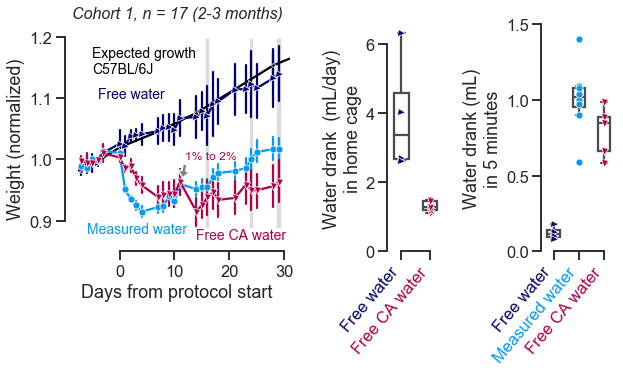

In [60]:
########### PLOTS ########### 
palette = sns.xkcd_palette(['black', 'deep blue', 'azure', 'raspberry'])
hue_order = ['Jax', 'Free water', 'Measured water', 'Citric Acid']

f, ax = plt.subplots(ncols=3, nrows=1, gridspec_kw=dict(width_ratios=[3, 0.75, 1]), figsize=(9, 6))
    
sns.lineplot(x="session_day", y="avg_weight", estimator=np.mean, err_style='bars', 
             style='condition', markers={'Jax':'.', 'Free water':'>', 'Measured water':'o', 'Citric Acid':'v'}, 
             dashes=False, markersize=7,
             ci=68, hue="condition", data=normalized2, ax=ax[0], legend=False, 
            palette=palette, hue_order=hue_order)
ax[0].set_xlabel("Days from protocol start")    
ax[0].set_ylabel("Weight (normalized)")         
ax[0].set(ylim=[0.85, 1.22], yticks=[0.9, 1, 1.1, 1.2], xticks=[0, 10, 20, 30], xlim=[-10, 31])
ax[0].text(-5, 1.14,'Expected growth\nC57BL/6J', {'color':palette[0], 'fontsize':14})
ax[0].text(-4, 1.10,'Free water', {'color':palette[1], 'fontsize':14})
ax[0].text(-6, 0.88,'Measured water', {'color':palette[2], 'fontsize':14})
#ax[0].text(-2, 0.81,'40 $\mu$L/g/day', {'color':palette[2], 'fontsize':16})
ax[0].text(14, 0.87,'Free CA water', {'color':palette[3], 'fontsize':14})
ax[0].annotate('1% to 2%', xy=(11.5, 0.97), xytext=(12, 1), color=palette[3], fontsize=12,
              arrowprops=dict(facecolor='grey', shrink=0, headlength=7))
#ax[0].text(-2, 1.17, 'Cohort 1\nn = 17\n2-3 months', {'color':'k', 'fontsize':16})
ax[0].set_title('Cohort 1, n = 17 (2-3 months)', fontsize=16, fontstyle='italic')

# add measurement days for (c) into this plot
ax[0].axvspan(15.5, 16.5, 0.1, 0.94, fc='gainsboro')
ax[0].axvspan(23.5, 24.5, 0.1, 0.94, fc='gainsboro')
ax[0].axvspan(28.5, 29.5, 0.1, 0.94, fc='gainsboro')

########### WATER ADMINISTRATIONS ########### 
water_with_date = (action.WaterAdministration & subj).proj('watertype_name', 'water_administered', 'adlib', # it can restrict on the subj here but it will anyway do later
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date) & 'session_date < "2018-10-24"'& 'session_date > "2018-10-05"'
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')
b = subj * total_water_date # including water will exclude mice with ad lib water
df = pd.DataFrame(b.fetch(as_dict=True))

########### CONDITIONS ########### 
df['condition'] = df.subject_nickname.map(condition_map)

########### b ########### 
sns.lineplot(x="condition", y="total_water", style='condition', markers={'Free water':'>', 'Measured water':'o', 'Citric Acid': 'v'}, 
             ci=None, units='subject_uuid', hue_order=['Free water', 'Citric Acid'], palette=sns.xkcd_palette(['deep blue', 'raspberry']),
             hue="condition", 
             data=df.groupby(['condition', 'subject_uuid'])['total_water'].mean().reset_index(),
             estimator=None, legend=False, dashes=None, markersize=7,
             ax=ax[1], zorder=100)

sns.boxplot(x="condition", y="total_water", order=[ 'Free water', 'Citric Acid'], 
            data=df.groupby(['subject_uuid', 'condition'])['total_water'].mean().reset_index(), 
            fliersize=0, boxprops={'facecolor':'None'}, width=.5, ax=ax[1],
           zorder=-100)
ax[1].set(ylabel='Water drank  (mL/day)\nin home cage', xlabel='')
ax[1].set_xticklabels(['Free water', 'Free CA water'])
ax[1].set_yticks([0, 2, 4, 6])

########### WATER ########### 
water= pd.read_csv('data/thirst.csv') # first date is exclude (habituation)
# remove measurements from 4-10-2018, CA mice still on 1%
water = water[~water['date'].str.match('4-10-2018')]
water['condition'] = water.subject.map(condition_map)

########### c ########### 
# sns.swarmplot(x="condition", y="water_amount", order=hue_order,  
#               data=,
#               ax=ax[2], palette=palette)

sns.lineplot(x="condition", y="water_amount", style='condition', markers={'Free water':'>', 'Measured water':'o', 'Citric Acid':'v'}, 
             ci=None, units='subject', hue_order=hue_order, palette=palette, hue="condition", 
             data=water.groupby(['condition', 'subject'])['water_amount'].mean().reset_index(),
             estimator=None, legend=False, dashes=None, markersize=7,
             ax=ax[2], zorder=100)
sns.boxplot(x="condition", y="water_amount", order=hue_order[1:], 
            data=water.groupby(['condition', 'subject'])['water_amount'].mean().reset_index(),
            fliersize=0, boxprops={'facecolor':'None'}, width=.5, ax=ax[2], zorder=-100)
ax[2].set(ylabel='Water drank (mL)\nin 5 minutes', xlabel='')
ax[2].set_xticklabels(['Free water', 'Measured water', 'Free CA water'])
ax[2].set_yticks([0, 0.5, 1, 1.5])

# layout with rotated ticks
for ticklabel, tickcolor in zip(ax[1].get_xticklabels(), [palette[1], palette[3]]):
    ticklabel.set_color(tickcolor)
    ticklabel.set_rotation(50)
    ticklabel.set(ha='right')
    
for ticklabel, tickcolor in zip(ax[2].get_xticklabels(), [palette[1], palette[2], palette[3]]):
    ticklabel.set_color(tickcolor)
    ticklabel.set_rotation(50)
    ticklabel.set(ha='right')
    
f.tight_layout(rect=[0, 0.03, 1, 0.95])
sns.despine(trim=True)
f.savefig(os.path.join(figpath, "citricacid_study1.pdf"))
f.savefig(os.path.join(figpath, "citricacid_study1.png"), dpi=600)

In [20]:
water.groupby(['condition', 'subject'])['water_amount'].mean().reset_index().groupby(['condition']).describe()

water_amount                                                    \
                      count      mean       std       min       25%       50%   
condition                                                                       
Citric Acid             5.0  0.795333  0.165875  0.583333  0.666667  0.850000   
Free water              4.0  0.122500  0.042284  0.083333  0.095833  0.113333   
Measured water          8.0  1.011250  0.226624  0.590000  0.955833  1.021667   

                                    
                     75%       max  
condition                           
Citric Acid     0.890000  0.986667  
Free water      0.140000  0.180000  
Measured water  1.083333  1.406667

In [21]:
# NOW DO THE SAME FOR WATER
water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib',
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date)
# total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
#                                    watertype="CONCAT_WS('; ', watertype_name)")
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')
water_df = subj * total_water_date
water_df = pd.DataFrame(water_df.fetch(as_dict=True))
water_df['condition'] = water_df.subject_nickname.map(condition_map)
water_df

#water_df.groupby(['condition'])['total_water'].describe()

,subject_uuid,subject_project,session_date,subject_nickname,sex,subject_birth_date,ear_mark,subject_line,subject_source,protocol_number,subject_description,subject_ts,subject_strain,lab_name,subjectlab_ts,subjectproject_ts,total_water,watertype,adlib,condition
0,0124f697-16ce-4f59-b87c-e53fcb3a27ac,collab_citricacid,2018-09-26,6867,M,2018-06-25,None,Thy1-GCaMP6s,CCU - Margarida colonies,1,None,2019-09-25 01:33:25,C57BL/6J,mainenlab,2020-05-06 13:42:52,2020-05-06 13:42:35,3.000000,Water 1% Citric Acid,1,Citric Acid
1,0124f697-16ce-4f59-b87c-e53fcb3a27ac,collab_citricacid,2018-09-27,6867,M,2018-06-25,None,Thy1-GCaMP6s,CCU - Margarida colonies,1,None,2019-09-25 01:33:25,C57BL/6J,mainenlab,2020-05-06 13:42:52,2020-05-06 13:42:35,1.000000,Water 1% Citric Acid,1,Citric Acid
2,0124f697-16ce-4f59-b87c-e53fcb3a27ac,collab_citricacid,2018-09-28,6867,M,2018-06-25,None,Thy1-GCaMP6s,CCU - Margarida colonies,1,None,2019-09-25 01:33:25,C57BL/6J,mainenlab,2020-05-06 13:42:52,2020-05-06 13:42:35,1.000000,Water 1% Citric Acid,1,Citric Acid
3,0124f697-16ce-4f59-b87c-e53fcb3a27ac,collab_citricacid,2018-10-01,6867,M,2018-06-25,None,Thy1-GCaMP6s,CCU - Margarida colonies,1,None,2019-09-25 01:33:25,C57BL/6J,mainenlab,2020-05-06 13:42:52,2020-05-06 13:42:35,0.666667,Water 1% Citric Acid,1,Citric Acid
4,0124f697-16ce-4f59-b87c-e53fcb3a27ac,collab_citricacid,2018-10-02,6867,M,2018-06-25,None,Thy1-GCaMP6s,CCU - Margarida colonies,1,None,2019-09-25 01:33:25,C57BL/6J,mainenlab,2020-05-06 13:42:52,2020-05-06 13:42:35,1.000000,Water 1% Citric Acid,1,Citric Acid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-10-16,ZM_338,M,2018-08-08,None,Thy1-GCaMP6s,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,C57BL/6J,mainenlab,2020-05-06 13:43:06,2020-05-06 13:42:50,0.730000,Water,0,Measured water
382,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-10-17,ZM_338,M,2018-08-08,None,Thy1-GCaMP6s,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,C57BL/6J,mainenlab,2020-05-06 13:43:06,2020-05-06 13:42:50,0.750000,Water,0,Measured water
383,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-10-19,ZM_338,M,2018-08-08,None,Thy1-GCaMP6s,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,C57BL/6J,mainenlab,2020-05-06 13:43:06,2020-05-06 13:42:50,0.770000,Water,0,Measured water
384,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-10-20,ZM_338,M,2018-08-08,None,Thy1-GCaMP6s,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,C57BL/6J,mainenlab,2020-05-06 13:43:06,2020-05-06 13:42:50,1.550000,Water,0,Measured water


In [22]:
water_measured = water_df.loc[water_df.condition == 'Measured water', :]
#sns.distplot(water_measured.total_water, kde=False, rug=True)
water_measured.describe()

,protocol_number,total_water,adlib
count,160.0,160.000000,160.0
mean,1.0,0.842625,0.0
std,0.0,0.346418,0.0
min,1.0,0.600000,0.0
25%,1.0,0.600000,0.0
50%,1.0,0.730000,0.0
75%,1.0,1.000000,0.0
max,1.0,2.300000,0.0
